In [4]:
import cv2
import numpy as np
import random
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, Flatten, Activation, Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# prepare data

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

unlabeld_index = np.ones(y_train.shape, np.bool)

N = 20
for i in range(10):
  idx = np.where(y_train == i)[0][:N]
  unlabeld_index[idx] = 0

x_unlabeld = x_train[np.where(unlabeld_index)[0], ...]

x_train = x_train[np.where(~unlabeld_index)[0], ...]
y_train = y_train[np.where(~unlabeld_index)[0], ...]

170498071/170498071 [==============================] - 14s 0us/step


<ipython-input-5-1db45bc5de0d>:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  unlabeld_index = np.ones(y_train.shape, np.bool)


#**<font color=#c94ce6>Define hyperparameters</font>**

In [6]:
INPUT_SHAPE = x_train.shape[1:]
EPOCHS = 50
BATCH_SIZE = 32
NUM_CLASSES = 10

#**<font color=#4589ad>Make y_train and y-test categorical</font>**

In [7]:
y_train = to_categorical(y_train, num_classes=NUM_CLASSES)
y_test = to_categorical(y_test, num_classes=NUM_CLASSES)

In [8]:
# examples of categorical crossentropy
cce = keras.losses.CategoricalCrossentropy()

# a labeled data from the second class
y_true = [[0, 1, 0, 0]]
y_pred = [[0.05, 0.95, 0, 0]]
print(cce(y_true, y_pred).numpy())

# an ulabeled data
y_true = [[0, 0, 0, 0]]
y_pred = [[0.05, 0.95, 0, 0]]
print(cce(y_true, y_pred).numpy())

# another ulabeled data
y_true = [[0, 0, 0, 0]]
y_pred = [[0.1, 0.4, 0.3, 0.2]]
print(cce(y_true, y_pred).numpy())

0.051293306
0.0
0.0


#**<font color="orange">Define model</font>**

In [9]:
def model_maker(input_shape=INPUT_SHAPE):
  inputs = Input(shape=(input_shape))
  x = Conv2D(32, (3, 3), activation='relu')(inputs)
  x = BatchNormalization(axis=-1)(x)
  x = MaxPool2D(pool_size=(3, 3))(x)
  x = Dropout(rate=0.25)(x)

  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = BatchNormalization(axis=-1)(x)
  x = MaxPool2D(pool_size=(2, 2))(x)
  x = Dropout(rate=0.25)(x)

  x = Conv2D(128, (3, 3), activation='relu')(x)
  x = BatchNormalization(axis=-1)(x)
  x = MaxPool2D(pool_size=(2, 2))(x)
  x = Dropout(rate=0.25)(x)

  x = Flatten()(x)
  x = Dense(1024, activation='relu')(x)
  x = BatchNormalization()(x)
  output = Dropout(rate=0.5)(x)

  model = Model(inputs=inputs, outputs=output, name='base')
  return model

In [10]:
model_maker().summary()

Model: "base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 10, 10, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496  

#**<font color=#e32929>Define plot function</font>**

In [11]:
def plot(history, title):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.tight_layout(pad=4)
  fig.suptitle(title)

  ax1.set_title('Accuracy')
  ax1.plot(acc)
  ax1.plot(val_acc)
  ax1.set_ylabel('accuracy')
  ax1.set_xlabel('epoch')
  ax1.legend(['training', 'validation'], loc='lower right')

  ax2.set_title('Loss')
  ax2.plot(loss)
  ax2.plot(val_loss)
  ax2.set_ylabel('loss')
  ax2.set_xlabel('epoch')
  ax2.legend(['training', 'validation'], loc='upper right')

  fig.show()

#**<font color="cyan">Q3.A</font>**

In [12]:
base_model = model_maker()
model_1 = Sequential()
model_1.add(base_model)
model_1.add(Dense(units=10, activation='softmax'))

##**<font color=#d0f002>Q3.A) Compile model</font>**

In [13]:
model_1.compile(
  optimizer=Adam(0.001),
  loss=CategoricalCrossentropy(),
  metrics=['accuracy'],
)
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base (Functional)           (None, 1024)              230336    
                                                                 
 dense_2 (Dense)             (None, 10)                10250     
                                                                 
Total params: 240,586
Trainable params: 238,090
Non-trainable params: 2,496
_________________________________________________________________


##**<font color=#d0f002>Q3.A) Fit model</font>**

In [14]:
history = model_1.fit(
  x_train, y_train,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_data=[x_test, y_test],
  verbose=2
)

Epoch 1/50
7/7 - 11s - loss: 3.5385 - accuracy: 0.1150 - val_loss: 2.2961 - val_accuracy: 0.1375 - 11s/epoch - 2s/step
Epoch 2/50
7/7 - 1s - loss: 2.7972 - accuracy: 0.1950 - val_loss: 2.2904 - val_accuracy: 0.1556 - 849ms/epoch - 121ms/step
Epoch 3/50
7/7 - 1s - loss: 2.7748 - accuracy: 0.2250 - val_loss: 2.2915 - val_accuracy: 0.1046 - 832ms/epoch - 119ms/step
Epoch 4/50
7/7 - 1s - loss: 2.4352 - accuracy: 0.3000 - val_loss: 2.3025 - val_accuracy: 0.1002 - 884ms/epoch - 126ms/step
Epoch 5/50
7/7 - 1s - loss: 2.3834 - accuracy: 0.3500 - val_loss: 2.3219 - val_accuracy: 0.1000 - 1s/epoch - 188ms/step
Epoch 6/50
7/7 - 1s - loss: 2.2764 - accuracy: 0.2950 - val_loss: 2.3430 - val_accuracy: 0.1000 - 851ms/epoch - 122ms/step
Epoch 7/50
7/7 - 1s - loss: 2.1960 - accuracy: 0.3750 - val_loss: 2.3652 - val_accuracy: 0.1008 - 859ms/epoch - 123ms/step
Epoch 8/50
7/7 - 1s - loss: 2.3269 - accuracy: 0.3150 - val_loss: 2.3966 - val_accuracy: 0.1011 - 860ms/epoch - 123ms/step
Epoch 9/50
7/7 - 1s - l

##**<font color=#d0f002>Q3.A) Plot results</font>**

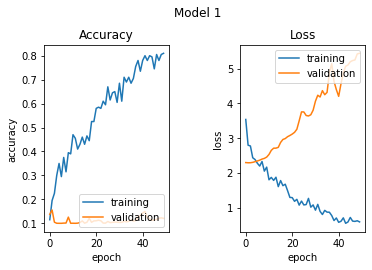

In [15]:
plot(history, "Model 1")

#**<font color="cyan">Q3.B</font>**

In [16]:
x_train_rotated = np.zeros_like(x_unlabeld)
y_train_rotated = np.zeros((x_unlabeld.shape[0], 4))

[0. 0. 0. 1.]


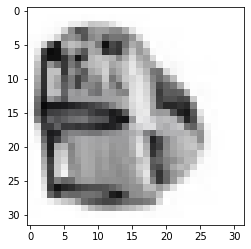

In [17]:
labels = [0, 1, 2, 3]

for i in range(x_train_rotated.shape[0]):
  label = random.choices(labels, weights=[1, 3, 3, 3], k=1)[0]
  if (label == 0):
    rotated_image = x_unlabeld[i]
  elif (label == 1):
    rotated_image = np.rot90(x_unlabeld[i])
  elif (label == 2):
    rotated_image = np.rot90(np.rot90(x_unlabeld[i]))
  else:
    rotated_image = np.rot90(np.rot90(np.rot90(x_unlabeld[i])))
  x_train_rotated[i] = rotated_image
  y_train_rotated[i] = to_categorical(label, num_classes=4)

plt.imshow(x_train_rotated[4], interpolation='nearest')
print(y_train_rotated[4])
plt.show()

In [18]:
base_model = model_maker()
model_test = Sequential()
model_test.add(base_model)
model_test.add(Dense(units=4, activation='softmax'))

##**<font color=#d0f002>Q3.B) Compile test model</font>**

In [19]:
model_test.compile(
  optimizer=Adam(0.001),
  loss=CategoricalCrossentropy(),
  metrics=['accuracy'],
)
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base (Functional)           (None, 1024)              230336    
                                                                 
 dense_2 (Dense)             (None, 10)                10250     
                                                                 
Total params: 240,586
Trainable params: 238,090
Non-trainable params: 2,496
_________________________________________________________________


##**<font color=#d0f002>Q3.B) Fit model</font>**

In [20]:
history = model_test.fit(
  x_train_rotated, y_train_rotated,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2,
)

Epoch 1/50
1245/1245 [==============================] - 8s 6ms/step - loss: 1.3767 - accuracy: 0.4484 - val_loss: 1.0961 - val_accuracy: 0.5289
Epoch 2/50
1245/1245 [==============================] - 7s 5ms/step - loss: 1.1111 - accuracy: 0.5340 - val_loss: 1.0098 - val_accuracy: 0.5805
Epoch 3/50
1245/1245 [==============================] - 7s 6ms/step - loss: 1.0656 - accuracy: 0.5543 - val_loss: 0.9702 - val_accuracy: 0.5957
Epoch 4/50
1245/1245 [==============================] - 7s 5ms/step - loss: 1.0248 - accuracy: 0.5770 - val_loss: 0.9256 - val_accuracy: 0.6151
Epoch 5/50
1245/1245 [==============================] - 7s 5ms/step - loss: 0.9801 - accuracy: 0.5933 - val_loss: 0.9096 - val_accuracy: 0.6208
Epoch 6/50
1245/1245 [==============================] - 7s 5ms/step - loss: 0.9531 - accuracy: 0.6069 - val_loss: 0.8688 - val_accuracy: 0.6463
Epoch 7/50
1245/1245 [==============================] - 7s 6ms/step - loss: 0.9281 - accuracy: 0.6208 - val_loss: 0.8888 - val_accuracy:

##**<font color=#d0f002>Q3.B) Plot results</font>**

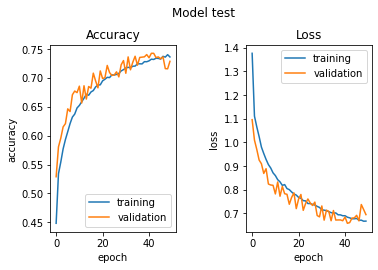

In [21]:
plot(history, "Model test")

In [23]:
model_2 = Sequential()
model_2.add(model_test.layers[0])
model_2.add(Dense(units=10, activation='softmax'))

##**<font color=#d0f002>Q3.B) Compile new model</font>**

In [27]:
model_2.compile(
  optimizer=Adam(learning_rate=0.0001),
  loss=CategoricalCrossentropy(),
  metrics=['accuracy'],
)
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base (Functional)           (None, 1024)              230336    
                                                                 
 dense_5 (Dense)             (None, 10)                10250     
                                                                 
Total params: 240,586
Trainable params: 238,090
Non-trainable params: 2,496
_________________________________________________________________


##**<font color=#d0f002>Q3.B) Fit new model</font>**

In [25]:
history = model_2.fit(
  x_train, y_train,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_data=[x_test, y_test],
)

Epoch 1/50
7/7 [==============================] - 2s 194ms/step - loss: 2.3400 - accuracy: 0.0900 - val_loss: 2.3032 - val_accuracy: 0.1123
Epoch 2/50
7/7 [==============================] - 1s 141ms/step - loss: 2.3393 - accuracy: 0.0800 - val_loss: 2.2969 - val_accuracy: 0.1221
Epoch 3/50
7/7 [==============================] - 1s 147ms/step - loss: 2.3000 - accuracy: 0.1150 - val_loss: 2.2911 - val_accuracy: 0.1286
Epoch 4/50
7/7 [==============================] - 1s 145ms/step - loss: 2.2974 - accuracy: 0.1400 - val_loss: 2.2855 - val_accuracy: 0.1347
Epoch 5/50
7/7 [==============================] - 1s 219ms/step - loss: 2.2929 - accuracy: 0.1000 - val_loss: 2.2803 - val_accuracy: 0.1418
Epoch 6/50
7/7 [==============================] - 1s 146ms/step - loss: 2.2838 - accuracy: 0.1100 - val_loss: 2.2752 - val_accuracy: 0.1484
Epoch 7/50
7/7 [==============================] - 1s 219ms/step - loss: 2.2690 - accuracy: 0.1250 - val_loss: 2.2701 - val_accuracy: 0.1559
Epoch 8/50
7/7 [====

##**<font color=#d0f002>Q3.B) Plot results new model</font>**

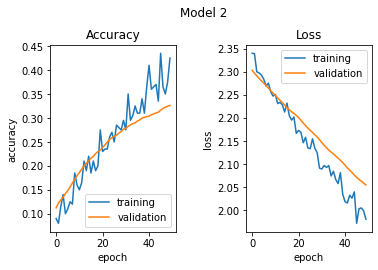

In [26]:
plot(history, "Model 2")

#**<font color="cyan">Q3.C</font>**

In [32]:
def final_model():
  base_model = Sequential([model_maker()])
  classifier = Dense(10, activation='softmax', name='classifier')(base_model.outputs[0])
  pretrained = Dense(4, activation='softmax', name='pretrained')(base_model.outputs[0])
  end_model = Model(inputs=base_model.inputs, outputs=[classifier, pretrained])
  return end_model

##**<font color=#d0f002>Q3.C) History of two outputs model</font>**

In [33]:
final_model().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 base_input (InputLayer)        [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 base (Functional)              (None, 1024)         230336      ['base_input[0][0]']             
                                                                                                  
 classifier (Dense)             (None, 10)           10250       ['base[0][0]']                   
                                                                                                  
 pretrained (Dense)             (None, 4)            4100        ['base[0][0]']                   
                                                                                              

##**<font color=#d0f002>Q3.C) Prepare data </font>**

In [36]:
y_train_class = np.concatenate((y_train, np.zeros((x_train_rotated.shape[0], 10))), axis=0)
y_train_rot = np.concatenate((np.zeros((y_train.shape[0], 4)), y_train_rotated), axis=0)

x_train_two = np.concatenate((x_train, x_train_rotated), axis=0)
y_train_two = [y_train_class, y_train_rot]

print(x_train_two.shape)
print(y_train_two[0].shape)
print(y_train_two[1].shape)

(50000, 32, 32, 3)
(50000, 10)
(50000, 4)


##**<font color=#d0f002>Q3.C) State 1</font>**

In [38]:
model_3 = final_model()
model_3.compile(
  optimizer=Adam(0.001),
  metrics=['accuracy'],
  loss_weights={
        'classifier': 10,
        'pretrained': 1
    },
  loss=CategoricalCrossentropy(),
)

In [39]:
history = model_3.fit(
  x_train_two, y_train_two,
  batch_size=BATCH_SIZE,
  epochs=15,
  validation_data=(x_test, {'classifier': y_test})
)

Epoch 1/15
1563/1563 [==============================] - 12s 7ms/step - loss: 1.7984 - classifier_loss: 0.0137 - pretrained_loss: 1.6614 - classifier_accuracy: 0.0973 - pretrained_accuracy: 0.3086 - val_loss: 25.7117 - val_classifier_loss: 2.5712 - val_pretrained_loss: 0.0000e+00 - val_classifier_accuracy: 0.0978 - val_pretrained_accuracy: 0.0000e+00
Epoch 2/15
1563/1563 [==============================] - 11s 7ms/step - loss: 1.9967 - classifier_loss: 0.0178 - pretrained_loss: 1.8185 - classifier_accuracy: 0.0974 - pretrained_accuracy: 0.3026 - val_loss: 30.3745 - val_classifier_loss: 3.0375 - val_pretrained_loss: 0.0000e+00 - val_classifier_accuracy: 0.1017 - val_pretrained_accuracy: 0.0000e+00
Epoch 3/15
1563/1563 [==============================] - 11s 7ms/step - loss: 2.1897 - classifier_loss: 0.0192 - pretrained_loss: 1.9979 - classifier_accuracy: 0.0987 - pretrained_accuracy: 0.2928 - val_loss: 26.4854 - val_classifier_loss: 2.6485 - val_pretrained_loss: 0.0000e+00 - val_classifier

##**<font color=#d0f002>Q3.C) State 2</font>**

In [40]:
model_3 = final_model()
model_3.compile(
  optimizer=Adam(0.001),
  metrics=['accuracy'],
  loss_weights={
        'classifier': 1,
        'pretrained': 10
    },
  loss=CategoricalCrossentropy(),
)

In [41]:
history = model_3.fit(
  x_train_two, y_train_two,
  batch_size=BATCH_SIZE,
  epochs=15,
  validation_data=(x_test, {'classifier': y_test})
)

Epoch 1/15
1563/1563 [==============================] - 12s 7ms/step - loss: 14.6283 - classifier_loss: 0.0107 - pretrained_loss: 1.4618 - classifier_accuracy: 0.1053 - pretrained_accuracy: 0.4193 - val_loss: 2.3593 - val_classifier_loss: 2.3593 - val_pretrained_loss: 0.0000e+00 - val_classifier_accuracy: 0.1041 - val_pretrained_accuracy: 0.0000e+00
Epoch 2/15
1563/1563 [==============================] - 11s 7ms/step - loss: 16.7652 - classifier_loss: 0.0130 - pretrained_loss: 1.6752 - classifier_accuracy: 0.1043 - pretrained_accuracy: 0.3688 - val_loss: 2.4978 - val_classifier_loss: 2.4978 - val_pretrained_loss: 0.0000e+00 - val_classifier_accuracy: 0.1101 - val_pretrained_accuracy: 0.0000e+00
Epoch 3/15
1563/1563 [==============================] - 11s 7ms/step - loss: 19.7064 - classifier_loss: 0.0146 - pretrained_loss: 1.9692 - classifier_accuracy: 0.1048 - pretrained_accuracy: 0.3201 - val_loss: 2.4371 - val_classifier_loss: 2.4371 - val_pretrained_loss: 0.0000e+00 - val_classifier

##**<font color=#d0f002>Q3.C) State 3</font>**

In [42]:
model_3 = final_model()
model_3.compile(
  optimizer=Adam(0.001),
  metrics=['accuracy'],
  loss_weights={
        'classifier': 1,
        'pretrained': 1
    },
  loss=CategoricalCrossentropy(),
)

In [43]:
history = model_3.fit(
  x_train_two, y_train_two,
  batch_size=BATCH_SIZE,
  epochs=15,
  validation_data=(x_test, {'classifier': y_test})
)

Epoch 1/15
1563/1563 [==============================] - 12s 7ms/step - loss: 1.6134 - classifier_loss: 0.0118 - pretrained_loss: 1.6016 - classifier_accuracy: 0.1073 - pretrained_accuracy: 0.3550 - val_loss: 2.4684 - val_classifier_loss: 2.4684 - val_pretrained_loss: 0.0000e+00 - val_classifier_accuracy: 0.0867 - val_pretrained_accuracy: 0.0000e+00
Epoch 2/15
1563/1563 [==============================] - 11s 7ms/step - loss: 1.8130 - classifier_loss: 0.0161 - pretrained_loss: 1.7969 - classifier_accuracy: 0.1011 - pretrained_accuracy: 0.3331 - val_loss: 2.6809 - val_classifier_loss: 2.6809 - val_pretrained_loss: 0.0000e+00 - val_classifier_accuracy: 0.0898 - val_pretrained_accuracy: 0.0000e+00
Epoch 3/15
1563/1563 [==============================] - 16s 10ms/step - loss: 1.9860 - classifier_loss: 0.0193 - pretrained_loss: 1.9667 - classifier_accuracy: 0.1002 - pretrained_accuracy: 0.3123 - val_loss: 2.5807 - val_classifier_loss: 2.5807 - val_pretrained_loss: 0.0000e+00 - val_classifier_a